In [7]:
import tkinter as tk
import ttkbootstrap as tb
from tkinter import *
from tkinter import filedialog, ttk
from ttkbootstrap.constants import *

import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
import cartopy.crs as ccrs

import imageio.v2 as imageio
from PIL import Image, ImageTk
import time

import sys
import os
import netCDF4 as nc
import numpy as np

class NC2:
    def __init__(self, root, file_path=None):
        self.root = root
        self.root.title("NC²")
        
        self.file_path = file_path
        self.dataset = None
        self.variable_names = []
        self.depth_levels = []
        self.current_figure = None
        self.forward_pressed = False
        self.backward_pressed = False
        
        self.create_widgets()
        
        if self.file_path:
            self.load_netcdf_file()

            
# ********** Widgets ********** #

    def create_widgets(self):
        control_frame_left = tk.Frame(self.root, padx=10, pady=10)
        control_frame_left.pack(side=tk.LEFT, fill=tk.Y)
        
        self.logo_image = ImageTk.PhotoImage(file="Logo3.png")
        width, height = self.logo_image.width(), self.logo_image.height()
        self.logo = Label(control_frame_left, width=width, height=height, image = self.logo_image)
        self.logo.pack(pady=5)
        
        self.select_file_button = tb.Button(control_frame_left, text="Select NetCDF File", command=self.select_file, bootstyle='info-outline')
        self.select_file_button.pack(pady=10)
        
        self.variable_dropdown_label = tb.Label(control_frame_left, text="Select Variable:", font=("Helvetica", 12))
        self.variable_dropdown_label.pack(pady=5)
        
        self.variable_dropdown = tb.Combobox(control_frame_left, state="readonly", bootstyle='primary')
        self.variable_dropdown.pack(pady=5)
        self.variable_dropdown.bind("<<ComboboxSelected>>", self.on_variable_selected)
        
        self.time_dropdown_label = tb.Label(control_frame_left, text="Select Time Step:", font=("Helvetica", 12))
        self.time_dropdown_label.pack(pady=5)
        
        self.time_dropdown = tb.Combobox(control_frame_left, state="readonly", bootstyle='primary')
        self.time_dropdown.pack(pady=5)
        self.time_dropdown.configure(state='disabled')
        self.time_dropdown.bind("<<ComboboxSelected>>", self.calculate_time)

        self.depth_dropdown_label = tb.Label(control_frame_left, text="Select Depth Level:", font=("Helvetica", 12))
        self.depth_dropdown_label.pack(pady=5)
        
        self.depth_dropdown = tb.Combobox(control_frame_left, state="readonly", bootstyle='primary')
        self.depth_dropdown.pack(pady=5)
        self.depth_dropdown.configure(state='disabled')
        self.depth_dropdown.bind("<<ComboboxSelected>>", self.calculate_depth)

        self.depth_time_label = tb.Label(control_frame_left, text='', bootstyle='warning')
        self.depth_time_label.pack(pady=10)
        
        self.statistics_label = tb.Label(control_frame_left, text='', bootstyle='info')
        self.statistics_label.pack(pady=5)
        
        self.hover_label = tb.Label(control_frame_left, text='', font=("Helvetica", 12),bootstyle='warning')
        self.hover_label.pack(pady=10)
        
        self.gif_checkbox_var = tk.BooleanVar()
        self.gif_checkbox = tb.Checkbutton(control_frame_left, text="Save as GIF", variable=self.gif_checkbox_var, bootstyle='danger, round-toggle', command=self.toggle_gif_checkbox)
        self.gif_checkbox.pack(pady=5)
        
        self.gif_FPS_label = tb.Label(control_frame_left, text="FPS (Frames Per Second)", font=("Helvetica", 12))
        self.gif_FPS_label.pack(pady=5)
        self.gif_FPS_entry = tb.Entry(control_frame_left, text='FPS (Frames Per Second)', bootstyle='warning')
        self.gif_FPS_entry.pack(pady=5)
        
        self.delete_images_var = tk.BooleanVar()
        self.delete_images_checkbox = tb.Checkbutton(control_frame_left, text="Delete Images", variable=self.delete_images_var, bootstyle='danger, round-toggle')
        self.delete_images_checkbox.pack(pady=5)
        
        self.gif_loop_var = tk.BooleanVar()
        self.gif_loop = tb.Checkbutton(control_frame_left, text="Loop", variable=self.gif_loop_var, bootstyle='danger, round-toggle')
        self.gif_loop.pack(pady=5)
     
        self.gif_directory = tb.Button(control_frame_left, text='Save GIF', command=self.select_gif_directory, bootstyle='warning-outline')
        self.gif_directory.pack(pady=5)

        self.plot_button = tb.Button(control_frame_left, text="Plot Variable", command=self.plot_variable, bootstyle='info-outline')
        self.plot_button.pack(side=tk.BOTTOM, pady=10)

        control_frame_right = tk.Frame(self.root, bg='grey16', padx=10, pady=10)
        control_frame_right.pack(side=tk.RIGHT, fill=tk.Y)
        
        self.plot_type_label = tb.Label(control_frame_right, text="Select Plot Type:", font=("Helvetica", 12))
        self.plot_type_label.pack(pady=5)
        
        self.plot_type_dropdown = tb.Combobox(control_frame_right, state="readonly", bootstyle='secondary')
        self.plot_type_dropdown['values'] = ['pcolormesh', 'contour', 'scatter']
        self.plot_type_dropdown.set('pcolormesh')
        self.plot_type_dropdown.pack(pady=5)
        
        self.colormap_dropdown_label = tb.Label(control_frame_right, text="Select Colormap:", font=("Helvetica", 12))
        self.colormap_dropdown_label.pack(pady=5)
        
        self.colormap_dropdown = tb.Combobox(control_frame_right, state="readonly", bootstyle='secondary')
        self.colormap_dropdown.pack(pady=5)
        
        self.load_colormaps()

        self.colorbar_orientation_label = tb.Label(control_frame_right, text="Colorbar Orientation:", font=("Helvetica", 12))
        self.colorbar_orientation_label.pack(pady=5)
        self.colorbar_orientation_dropdown = tb.Combobox(control_frame_right, state="readonly", bootstyle='secondary')
        self.colorbar_orientation_dropdown['values'] = ['left', 'right', 'top', 'bottom']
        self.colorbar_orientation_dropdown.set('right')
        self.colorbar_orientation_dropdown.pack(pady=5)
        
        self.cbar_shrink_label = tb.Label(control_frame_right, text='Colorbar Shrink [ 0-1 ]', font=("Helvetica", 12))
        self.cbar_shrink_label.pack(pady=5)
        self.cbar_shrink_entry = tb.Entry(control_frame_right, bootstyle='secondary')
        self.cbar_shrink_entry.pack(pady=5)
        
        self.vmax_label = tb.Label(control_frame_right, text="v-max:", font=("Helvetica", 12, 'bold'), bootstyle='success')
        self.vmax_label.pack(pady=5)
        self.vmax_entry = tb.Entry(control_frame_right, bootstyle='secondary')
        self.vmax_entry.pack(pady=5)
        
        self.vmin_label = tb.Label(control_frame_right, text="v-min:", font=("Helvetica", 12, 'bold'), bootstyle='danger')
        self.vmin_label.pack(pady=5)
        self.vmin_entry = tb.Entry(control_frame_right, bootstyle='secondary')
        self.vmin_entry.pack(pady=5)
        
        self.extent_label = tb.Label(control_frame_right, text="Manual Extents (x0, x1, y0, y1):", font=("Helvetica", 12))
        self.extent_label.pack(pady=5)
        self.extent_entry = tb.Entry(control_frame_right, bootstyle='secondary')
        self.extent_entry.pack(pady=5)
        
        self.xlabel_label = tb.Label(control_frame_right, text="X-axis Label:", font=("Helvetica", 12))
        self.xlabel_label.pack(pady=5)
        self.xlabel_entry = tb.Entry(control_frame_right, bootstyle='secondary')
        self.xlabel_entry.pack(pady=5)
        
        self.ylabel_label = tb.Label(control_frame_right, text="Y-axis Label:", font=("Helvetica", 12))
        self.ylabel_label.pack(pady=5)
        self.ylabel_entry = tb.Entry(control_frame_right, bootstyle='secondary')
        self.ylabel_entry.pack(pady=5)
        
        self.title_label = Label(control_frame_right, text="Plot Title:", font=("Helvetica", 12))
        self.title_label.pack(pady=5)
        self.title_entry = tb.Entry(control_frame_right, bootstyle='secondary')
        self.title_entry.pack(pady=5)
        
        self.theme_dropdown = tb.Menubutton(control_frame_right, text="Theme", bootstyle='secondary', direction='below')
        self.theme_menu = tb.Menu(self.theme_dropdown, tearoff=0)
        
        self.light_theme_menu = tb.Menu(self.theme_menu, tearoff=0)
        self.dark_theme_menu = tb.Menu(self.theme_menu, tearoff=0)

        for theme in ['cosmo', 'flatly', 'minty', 'morph', 'simplex']:
            self.light_theme_menu.add_command(label=theme, command=lambda t=theme: self.change_theme(t))
        
        for theme in ['solar', 'superhero', 'darkly', 'cyborg', 'vapor']:
            self.dark_theme_menu.add_command(label=theme, command=lambda t=theme: self.change_theme(t))
        
        self.theme_menu.add_cascade(label="Light Themes", menu=self.light_theme_menu)
        self.theme_menu.add_cascade(label="Dark Themes", menu=self.dark_theme_menu)

        self.theme_dropdown.config(menu=self.theme_menu)
        self.theme_dropdown.pack(pady=5)

        self.data_display_frame = tk.Frame(self.root, bg='grey14', padx=10, pady=5)
        self.data_display_frame.pack(side=tk.BOTTOM, fill=tk.X)

        self.data_display_text = tk.Text(self.data_display_frame, bg='grey12', fg='lime', height=10, wrap=tk.WORD, font=("Helvetica", 10))
        self.data_display_text.pack(fill=tk.BOTH, expand=True)

        self.plot_frame = tk.Frame(self.root, bg='grey12', padx=10, pady=10)
        self.plot_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        
# ********** Logic ********** #
    
    def load_colormaps(self):
        colormap_names = sorted(m for m in plt.colormaps() if not m.endswith("_r"))
        self.colormap_dropdown['values'] = colormap_names
        self.colormap_dropdown.set('jet') 
    
    def select_file(self):
        self.file_path = filedialog.askopenfilename(filetypes=[("NetCDF files", "*.nc*")])
        if self.file_path:
            self.load_netcdf_file()
    
    def load_netcdf_file(self):
        try:
            self.dataset = nc.Dataset(self.file_path)
            self.variable_names = list(self.dataset.variables.keys())
            self.variable_dropdown['values'] = self.variable_names

            time_keys = ['time', 'tau', 'month', 'year']
                
            self.time = None
            self.time_key = None

            for key in time_keys:
                if key in self.dataset.variables:
                    self.time = self.dataset.variables[key]
                    self.time_key = key
                    break


            if self.time is not None:
                self.time_units = self.time.units
                self.time_steps = len(self.time)
                time_values = [nc.num2date(self.time[t], units=self.time_units) for t in range(self.time_steps)]
                self.time_index_map = {str(time_values[i]): i for i in range(self.time_steps)}
                self.time_dropdown['values'] = list(self.time_index_map.keys())
                self.time_dropdown.set(list(self.time_index_map.keys())[0])
            else:
                self.time_dropdown.configure(state='disabled')
            
            depth_keys = ['depth', 'z', 'zlev']
            
            self.depth = None
            self.depth_key = None
            
            for key in depth_keys:
                if key in self.dataset.variables:
                    self.depth = self.dataset.variables[key]
                    self.depth_key = key
                    break
            
            if self.depth is not None:
                self.depth_units = self.depth.units
                self.depth_levels = len(self.depth)
                depth_values = [self.depth[d] for d in range(self.depth_levels)]
                self.depth_index_map = {str(depth_values[i]): i for i in range(self.depth_levels)}
                self.depth_dropdown['values'] = list(self.depth_index_map.keys())
                self.depth_dropdown.set(list(self.depth_index_map.keys())[0])
            else:
                self.depth_dropdown.configure(state='disabled')
                
            lat_keys = ['lat', 'latitude', 'lats', 'y']
            lon_keys = ['lon', 'longitude', 'lons', 'x']
                
            self.lat = None
            self.lon = None

            for key in lat_keys:
                if key in self.dataset.variables:
                    self.lat = self.dataset.variables[key][:]
                    self.lat_key = key
                    break


            for key in lon_keys:
                if key in self.dataset.variables:
                    self.lon = self.dataset.variables[key][:]
                    self.lon_key = key
                    break
            
            Dimensions = {self.time_key, self.depth_key, self.lat_key, self.lon_key}
            self.variable_names = [i for i in self.dataset.variables.keys() if i not in Dimensions]
            self.variable_dropdown['values'] = self.variable_names

            self.display_all_variable_info()
            
        except Exception as e:
            print(f"Error loading NetCDF file: {e}")
    
    def display_all_variable_info(self):
        self.data_display_text.delete("1.0", tk.END)
        for var_name, variable in self.dataset.variables.items():
            self.data_display_text.insert(tk.END, f"{var_name}: {repr(variable)}\n\n")

    def on_variable_selected(self, event):
        selected_variable = self.variable_dropdown.get()
        variable_data = self.dataset.variables[selected_variable]
        dims = variable_data.dimensions

        if self.depth_key in dims:
            self.depth_dropdown.configure(state='readonly')
        else:
            self.depth_dropdown.configure(state='disabled')
        if self.time_key in dims:
            self.time_dropdown.configure(state='readonly')
        else:
            self.time_dropdown.configure(state='disabled')
        

    def calculate_time(self, event=None):
        try:
            selected_time = self.time_dropdown.get()
            time_index = self.time_index_map[selected_time]
            global time_value
            time_value = nc.num2date(self.time[time_index], units=self.time_units)
            self.depth_time_label.config(text=f"{time_value}")
            self.show_statistics()
            
        except Exception as e:
            self.depth_time_label.config(text=f"Error calculating time: {e}")

    def calculate_depth(self, event=None):
        try:
            selected_depth = self.depth_dropdown.get()
            depth_index = self.depth_index_map[selected_depth]
            global depth_value
            depth_value = self.depth[depth_index]
            self.depth_time_label.config(text=f"{time_value} ({depth_value} {self.depth_units})")
            self.show_statistics()
            
        except Exception as e:
            self.depth_time_label.config(text=f"Error calculating depth: {e}")
            
    def show_statistics(self):
        selected_variable = self.variable_dropdown.get()
        variable_data = self.dataset.variables[selected_variable]
        
        variable_dims = variable_data.dimensions
    
        if len(variable_dims) == 3:
            selected_time_step = self.time_dropdown.get()
            time_index = self.time_index_map[selected_time_step]
            variable_data = variable_data[time_index, :, :]

        elif len(variable_dims) == 4:
            selected_time_step = self.time_dropdown.get()
            time_index = self.time_index_map[selected_time_step]
            selected_depth = self.depth_dropdown.get()
            depth_index = self.depth_index_map[selected_depth]
            variable_data = variable_data[time_index, depth_index, :, :]

        if np.ma.isMaskedArray(variable_data):
            variable_data = variable_data.compressed()
            
        mean = np.round(float(np.mean(variable_data)), 4)
        median = np.round(float(np.median(variable_data)), 4)
        std_dev = np.round(float(np.std(variable_data)), 4)
        min_val = np.round(float(np.min(variable_data)), 4)
        max_val = np.round(float(np.max(variable_data)), 4)
        
        anomalies = variable_data > mean + 2 * std_dev
        anomaly_count = np.sum(anomalies)
        
        stats_message = f"Mean: {mean}\nMedian: {median}\nStandard Deviation: {std_dev}\nDetected {anomaly_count} anomalies.\nMin: {min_val}\nMax: {max_val}"
        self.statistics_label.config(text=f"{stats_message}")
        
    def toggle_gif_checkbox(self):
        if self.gif_checkbox_var.get():
            self.time_dropdown.configure(state='disabled')
        else:
            self.time_dropdown.configure(state='readonly')
            
    def select_gif_directory(self):
            self.gif_dir = filedialog.askdirectory()
            if self.gif_dir:
                self.gif_directory.config(text=f"{self.gif_dir}")   
       
    def update_hover_info(self, event):
        if event.inaxes:
            lon = event.xdata
            lat = event.ydata
            selected_variable = self.variable_dropdown.get()
        
        # Find the closest index
            lon_idx = np.argmin(np.abs(self.lon - lon))
            lat_idx = np.argmin(np.abs(self.lat - lat))

        # Extract the data value
            if self.depth_key in self.dataset.variables[selected_variable].dimensions:
                depth_index = self.depth_index_map[self.depth_dropdown.get()]
                time_index = self.time_index_map[self.time_dropdown.get()]
                data_value = self.dataset.variables[selected_variable][time_index, depth_index, lat_idx, lon_idx]
            else:
                time_index = self.time_index_map[self.time_dropdown.get()]
                data_value = self.dataset.variables[selected_variable][time_index, lat_idx, lon_idx]
                
            if np.ma.is_masked(data_value):
                value_str = "Masked"
            else:
                value_str = f"{data_value:.2f}"

            hover_info = f"Lon: {lon:.2f}, Lat: {lat:.2f}\ni: {lon_idx} j: {lat_idx}\nValue: {value_str}"
            self.hover_label.config(text=hover_info)
            
    def forward(self):
        self.forward_pressed = True
        self.plot_variable()
        
    def backward(self):
        self.backward_pressed = True
        self.plot_variable()

    def plot_variable(self):
        
        class CustomToolbar(NavigationToolbar2Tk):
            def mouse_move(self, event):
                pass
            def set_message(self, s):
                pass
                            
        selected_variable = self.variable_dropdown.get()
        selected_colormap = self.colormap_dropdown.get()
        plot_type = self.plot_type_dropdown.get()
        colorbar_orientation = self.colorbar_orientation_dropdown.get()

        try:
            vmin = float(self.vmin_entry.get())
        except ValueError:
            vmin = None
        try:
            vmax = float(self.vmax_entry.get())
        except ValueError:
            vmax = None
            
        try:
            shrink = float(self.cbar_shrink_entry.get())
        except ValueError:
            shrink = 0.75
            
        manual_extent = None
        if self.extent_entry.get():
            try:
                x_min, x_max, y_min, y_max = map(float, self.extent_entry.get().split(','))
                manual_extent = [x_min, x_max, y_min, y_max]
            except ValueError:
                print("Invalid extent values. Please enter in the format: [x0, x1, y0, y1]")

        xlabel = self.xlabel_entry.get()
        ylabel = self.ylabel_entry.get()
        title = self.title_entry.get()

        if self.gif_checkbox_var.get():
            time_steps = range(self.time_steps)
        else:
            current_index = [self.time_dropdown.current()]
            
            if self.forward_pressed:
                current_index[0] += 1
                self.time_dropdown.current(current_index)
            else:
                current_index = current_index
                time_steps = current_index
            self.forward_pressed = False
            
            if self.backward_pressed:
                current_index[0] -= 1
                self.time_dropdown.current(current_index)
            else:
                current_index = current_index
                time_steps = current_index
            self.backward_pressed = False

        if selected_variable and self.dataset:
            for widget in self.plot_frame.winfo_children():
                widget.destroy()

            variable_data = self.dataset.variables[selected_variable]
            variable_dims = variable_data.dimensions

            if len(variable_dims) == 3:  
                         
                for t in time_steps:
                    try:
                        if self.gif_checkbox_var.get():
                            plt.ioff()
                            
                        time_value = nc.num2date(self.time[t], units=self.time_units)

                        data = variable_data[t, :, :] 

                        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

                        if plot_type == 'pcolormesh':
                            pcm = ax.pcolormesh(self.lon, self.lat, data, cmap=selected_colormap, vmin=vmin, vmax=vmax)
                        elif plot_type == 'contour':
                            pcm = ax.contour(self.lon, self.lat, data, cmap=selected_colormap, vmin=vmin, vmax=vmax)
                        elif plot_type == 'scatter':
                            pcm = ax.scatter(self.lon, self.lat, c=data, cmap=selected_colormap, vmin=vmin, vmax=vmax)
                        
                        cbar = plt.colorbar(pcm, ax=ax, location=colorbar_orientation, shrink=shrink)
                        
                        ax.coastlines(linewidth=.5)
        
                        gl = ax.gridlines(draw_labels=True, alpha=0)
                        gl.top_labels = False
                        gl.right_labels = False
                        if xlabel:
                            gl.bottom_labels = True
                            ax.text(0.5, -0.19, xlabel, va='bottom', ha='center', rotation='horizontal', rotation_mode='anchor', transform=ax.transAxes, fontsize=12)
                        if ylabel:
                            gl.left_labels = True
                            ax.text(-0.11, 0.5, ylabel, va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', transform=ax.transAxes, fontsize=12)

                        if title:
                            ax.set_title(f'{title} ({time_value})')
                        else:
                            ax.set_title(f'{selected_variable} ({time_value})')
                            
                        if manual_extent:
                            ax.set_extent(manual_extent, crs=ccrs.PlateCarree())
                            
                        if self.gif_checkbox_var.get():
                            fig.savefig(os.path.join(self.gif_dir, f'frame_{t:03d}.png'))
                            plt.close(fig)
                        else:
                            canvas = FigureCanvasTkAgg(fig, master=self.plot_frame)
                            canvas.draw()
                            canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
                            fig.canvas.mpl_connect('motion_notify_event', self.update_hover_info)
                            
                            controls_frame = tk.Frame(self.plot_frame)
                            controls_frame.pack(side=tk.TOP, fill=tk.X, pady=10)
                        
                            self.time_plot_button = tb.Button(controls_frame, text="Show Time Plot", command=self.time_series, bootstyle='info-outline')
                            self.time_plot_button.pack(side=tk.LEFT, padx=10)
                            self.backward_button = tb.Button(controls_frame, text="<<", command=self.backward, bootstyle='warning-outline')
                            self.backward_button.pack(side=tk.LEFT, padx=40)
                        
                            self.depth_plot_button = tb.Button(controls_frame, text="Show Depth Plot", command=self.depth_series, bootstyle='info-outline')
                            self.depth_plot_button.pack(side=tk.RIGHT, padx=10)
                            self.forward_button = tb.Button(controls_frame, text=">>", command=self.forward, bootstyle='warning-outline')
                            self.forward_button.pack(side=tk.RIGHT, padx=40)
                        
                            toolbar_frame = tk.Frame(controls_frame)
                            toolbar_frame.pack(side=tk.TOP, fill=tk.X, pady=5, padx=20)
                        
                            toolbar = CustomToolbar(canvas, toolbar_frame, pack_toolbar=False)
                            toolbar.update
                            toolbar.pack(side=tk.BOTTOM, padx=10)
                        
                        plt.close(fig)

                    except Exception as e:
                        print(f"Error plotting variable at time step {t}: {e}")

            
            elif len(variable_dims) == 4:  # [time, depth, lat, lon]

                selected_depth = self.depth_dropdown.get()
                selected_depth = self.depth_index_map[selected_depth]
                        
                for t in time_steps:
                    try:
                        if self.gif_checkbox_var.get():
                            plt.ioff()
                            
                        time_value = nc.num2date(self.time[t], units=self.time_units)

                        data = variable_data[t, selected_depth, :, :]  # Extract data for time step and depth

                        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
                        ax.coastlines(linewidth=.5)

                        if plot_type == 'pcolormesh':
                            pcm = ax.pcolormesh(self.lon, self.lat, data, cmap=selected_colormap, vmin=vmin, vmax=vmax)
                        elif plot_type == 'contour':
                            pcm = ax.contour(self.lon, self.lat, data, cmap=selected_colormap, vmin=vmin, vmax=vmax)
                        elif plot_type == 'scatter':
                            pcm = ax.scatter(self.lon, self.lat, c=data, cmap=selected_colormap, vmin=vmin, vmax=vmax)
                        
                        cbar = plt.colorbar(pcm, ax=ax, location=colorbar_orientation, shrink=shrink)

                        gl = ax.gridlines(draw_labels=True, alpha=0)
                        gl.top_labels = False
                        gl.right_labels = False
                        if xlabel:
                            gl.bottom_labels = True
                            ax.text(0.5, -0.17, xlabel, va='bottom', ha='center', rotation='horizontal', rotation_mode='anchor', transform=ax.transAxes, fontsize=12)
                        if ylabel:
                            gl.left_labels = True
                            ax.text(-0.12, 0.5, ylabel, va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', transform=ax.transAxes, fontsize=12)

                        if title:
                            ax.set_title(f'{title} {time_value} ({depth_value} m)')
                        else:
                            ax.set_title(f'{selected_variable} ({time_value}) ({depth_value} m)')
                            
                        if manual_extent:
                            ax.set_extent(manual_extent, crs=ccrs.PlateCarree())
                            
                        if self.gif_checkbox_var.get():
                            fig.savefig(os.path.join(self.gif_dir, f'frame_{t:03d}.png'))
                            plt.close(fig)
                        else:
                            canvas = FigureCanvasTkAgg(fig, master=self.plot_frame)
                            canvas.draw()
                            canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
                            fig.canvas.mpl_connect('motion_notify_event', self.update_hover_info)
                            
                            controls_frame = tk.Frame(self.plot_frame)
                            controls_frame.pack(side=tk.TOP, fill=tk.X, pady=10)
                        
                            self.time_plot_button = tb.Button(controls_frame, text="Show Time Plot", command=self.time_series, bootstyle='info-outline')
                            self.time_plot_button.pack(side=tk.LEFT, padx=10)
                            self.backward_button = tb.Button(controls_frame, text="<<", command=self.backward, bootstyle='warning-outline')
                            self.backward_button.pack(side=tk.LEFT, padx=40)
                        
                            self.depth_plot_button = tb.Button(controls_frame, text="Show Depth Plot", command=self.depth_series, bootstyle='info-outline')
                            self.depth_plot_button.pack(side=tk.RIGHT, padx=10)
                            self.forward_button = tb.Button(controls_frame, text=">>", command=self.forward, bootstyle='warning-outline')
                            self.forward_button.pack(side=tk.RIGHT, padx=40)
                        
                            toolbar_frame = tk.Frame(controls_frame)
                            toolbar_frame.pack(side=tk.TOP, fill=tk.X)
                        
                            toolbar = CustomToolbar(canvas, toolbar_frame, pack_toolbar=False)
                            toolbar.update
                            toolbar.pack(side=tk.BOTTOM, padx=10)
                            
                            
                        plt.close(fig)

                    except Exception as e:
                        print(f"Error plotting variable at time step {t}: {e}")
                               
            if self.gif_checkbox_var.get():
                gif_path = os.path.join(self.gif_dir, 'animation.gif')
                if self.gif_loop_var.get():
                    gifloop=0
                else:
                    gifloop=1    
                    
                gif_duration = 6
                if self.gif_FPS_entry.get():
                    gif_duration = float(self.gif_FPS_entry.get())
            
                with imageio.get_writer(gif_path, mode='I', fps=gif_duration, loop=gifloop) as writer:
                    for t in time_steps:
                        filename = os.path.join(self.gif_dir, f'frame_{t:03d}.png')
                        if os.path.exists(filename):
                            image = imageio.imread(filename)
                            writer.append_data(image)
                if self.delete_images_var.get():
                    for t in time_steps:
                        filename = os.path.join(self.gif_dir, f'frame_{t:03d}.png')
                        if os.path.exists(filename):
                            os.remove(filename)
                print(f"GIF saved at {gif_path}")
                
                self.show_gif_in_window(gif_path)

    def time_series(self):
        
        from scipy.optimize import curve_fit
        from scipy import stats
        
        xlabel = self.xlabel_entry.get()
        ylabel = self.ylabel_entry.get()
        title = self.title_entry.get()
        
        class CustomToolbar(NavigationToolbar2Tk):
            def mouse_move(self, event):
                pass
            def set_message(self, s):
                pass
        
        time_plot = Toplevel(self.root)
        time_plot.title("Time Series")
        time_plot.geometry("800x550")
    
        selected_variable = self.variable_dropdown.get()
        if not selected_variable or not self.dataset:
            return

        variable_data = self.dataset.variables[selected_variable]
        variable_dims = variable_data.dimensions

        if len(variable_dims) == 3:  # [time, lat, lon]
            data = np.mean((variable_data)[:, :, :], axis=(1, 2))  # Average over lat and lon
        elif len(variable_dims) == 4:  # [time, depth, lat, lon]
            selected_depth = self.depth_dropdown.get()
            selected_depth = self.depth_index_map[selected_depth]
            data = np.mean(variable_data[:, selected_depth, :, :], axis=(1, 2))  # Average over lat and lon

        time_values = range(self.time_steps)

        # Fit a linear regression line (you can change this to any desired function)
        def linear_func(x, a, b):
            return a * x + b

        popt, _ = curve_fit(linear_func, time_values, data)

    # Predicted values from the fitted line
        predicted_values = linear_func(time_values, *popt)

    # Calculate statistics
        slope, intercept, r_value, p_value, std_err = stats.linregress(time_values, data)
        mean_value = np.mean(data)
        std_deviation = np.std(data)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
        if ylabel:
            ax1.plot(time_values, data, label=f"{ylabel}", color='dodgerblue')
        else:
            ax1.plot(time_values, data, label=(f'{selected_variable}'), color='dodgerblue')
            
        ax1.plot(time_values, predicted_values, '--', label='Prediction', color='darkorange')
        
        if xlabel:
            ax1.set_xlabel(f"{xlabel}")
        else:
            ax1.set_xlabel("Time")
        if ylabel:
            ax1.set_ylabel(f"{ylabel}")
        else:
            ax1.set_ylabel(selected_variable)
        
        if title:
            plt.suptitle(f'{title}')
        else:
            plt.suptitle('Time Series')
            ax1.set_title(f"Time Series of {selected_variable}")
        ax1.legend()
        
    # Add statistics as text below the plot
        stats_text = f"Mean: {mean_value:.2f}\n"
        stats_text += f"Std Dev: {std_deviation:.2f}\n"
        stats_text += f"R-squared: {r_value**2:.2f}\n"
        stats_text += f"P-value: {p_value:.4f}\n"

        ax1.text(.01, 0.005, stats_text, transform=ax1.transAxes, fontsize=10, verticalalignment='bottom')
        
        ax2.hist(data, bins=15, edgecolor='black', alpha=0.7, color='dodgerblue')
        ax2.set_xlabel(selected_variable)
        ax2.set_title(f'Histogram of {selected_variable}')
        
        plt.subplots_adjust(hspace=0.3)
        fig.tight_layout()
        
        canvas = FigureCanvasTkAgg(fig, master=time_plot)
        canvas.draw()
        canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
        
        toolbar = CustomToolbar(canvas, pack_toolbar=False)
        toolbar.update()
        toolbar.pack(side=tk.BOTTOM, pady=10)
        
    def depth_series(self):
        from scipy.optimize import curve_fit
        from scipy import stats
        
        xlabel = self.xlabel_entry.get()
        ylabel = self.ylabel_entry.get()
        title = self.title_entry.get()
        
        class CustomToolbar(NavigationToolbar2Tk):
            def mouse_move(self, event):
                pass
            def set_message(self, s):
                pass
            
        depth_plot = Toplevel(self.root)
        depth_plot.title("Depth Series")
        depth_plot.geometry("800x550")
        
        selected_variable = self.variable_dropdown.get()
        if not selected_variable or not self.dataset:
            return

        variable_data = self.dataset.variables[selected_variable]

        selected_time = self.time_dropdown.get()
        selected_time = self.time_index_map[selected_time]
        data = np.mean(variable_data[selected_time, :, :, :], axis=(1, 2))  # Average over lat and lon
        
        depth_values = range(self.depth_levels)
        
        def linear_func(x, a, b):
            return a * x + b

        popt, _ = curve_fit(linear_func, depth_values, data)

    # Predicted values from the fitted line
        predicted_values = linear_func(depth_values, *popt)

    # Calculate statistics
        slope, intercept, r_value, p_value, std_err = stats.linregress(depth_values, data)
        mean_value = np.mean(data)
        std_deviation = np.std(data)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        if ylabel:
            ax1.plot(depth_values, data, label=f"{ylabel}")
        else:
            ax1.plot(depth_values, data, label=(f'{selected_variable}'))
            
        ax1.plot(depth_values, predicted_values, '--', label='Prediction', color='darkorange')
        
        if xlabel:
            ax1.set_xlabel(f"{xlabel}")
        else:
            ax1.set_xlabel("Depth (m)")
        if ylabel:
            ax1.set_ylabel(f"{ylabel}")
        else:
            ax1.set_ylabel(selected_variable)
        
        if title:
            plt.suptitle(f'{title}')
        else:
            plt.suptitle('Depth Series')
            ax1.set_title(f"Depth Series of {selected_variable}")
        ax1.legend()

    # Add statistics as text below the plot
        stats_text = f"Mean: {mean_value:.2f}\n"
        stats_text += f"Std Dev: {std_deviation:.2f}\n"
        stats_text += f"R-squared: {r_value**2:.2f}\n"
        stats_text += f"P-value: {p_value:.4f}\n"

        ax1.text(.01, 0.005, stats_text, transform=ax1.transAxes, fontsize=10, verticalalignment='bottom')
        
        ax2.hist(data, bins=15, edgecolor='black', alpha=0.7, color='dodgerblue')
        ax2.set_xlabel(selected_variable)
        ax2.set_title(f'Histogram of {selected_variable}')
        
        plt.subplots_adjust(hspace=0.3)
        fig.tight_layout()

        canvas = FigureCanvasTkAgg(fig, master=depth_plot)
        canvas.draw()
        canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
    
        toolbar = CustomToolbar(canvas, pack_toolbar=False)
        toolbar.update()
        toolbar.pack(side=tk.BOTTOM, pady=10)

    def show_gif_in_window(self, gif_path):
        gif_window = Toplevel(self.root)
        gif_window.title("GIF Preview")
        gif_window.geometry("800x520")

        gif_label = Label(gif_window)
        gif_label.pack()

        playback_control_frame = tk.Frame(gif_window)
        playback_control_frame.pack(pady=5)
        
        slow_button = tb.Button(playback_control_frame, text='<<', command=self.slow_gif, bootstyle='warning-outline')
        slow_button.pack(side=tk.LEFT, padx=5)

        play_button = tb.Button(playback_control_frame, text="Play", command=self.play_gif, bootstyle='success-outline')
        play_button.pack(side=tk.LEFT, padx=2)

        pause_button = tb.Button(playback_control_frame, text="Pause", command=self.pause_gif, bootstyle='warning-outline')
        pause_button.pack(side=tk.LEFT, padx=2)

        reverse_button = tb.Button(playback_control_frame, text="Reverse", command=self.reverse_gif, bootstyle='info-outline')
        reverse_button.pack(side=tk.LEFT,padx=2)

        stop_button = tb.Button(playback_control_frame, text="Stop", command=self.stop_gif, bootstyle='danger-outline')
        stop_button.pack(side=tk.LEFT,padx=2)
        
        speed_button = tb.Button(playback_control_frame, text='>>', command=self.speed_gif, bootstyle='warning-outline')
        speed_button.pack(side=tk.LEFT, padx=5)

        self.gif_frames = []
        self.gif_path = gif_path
        self.gif_label = gif_label
        self.gif_window = gif_window
        self.gif_playing = False
        self.gif_paused = False
        self.gif_reversed = False
        self.current_frame_index = 0
        self.playback_speed = 100

        with Image.open(gif_path) as gif:
            for frame in range(gif.n_frames):
                gif.seek(frame)
                frame_image = ImageTk.PhotoImage(gif.convert("RGBA"))
                self.gif_frames.append(frame_image)
                
        self.play_gif()
        
    def play_gif(self):
        self.gif_playing = True
        self.gif_paused = False
        self.gif_reversed = False
        self.update_gif()

    def pause_gif(self):
        self.gif_playing = False
        self.gif_paused = True

    def reverse_gif(self):
        self.gif_playing = True
        self.gif_paused = False
        self.gif_reversed = True
        self.update_gif()

    def stop_gif(self):
        self.gif_playing = False
        self.gif_paused = False
        self.gif_reversed = False
        self.current_frame_index = 0
        self.gif_label.configure(image=self.gif_frames[self.current_frame_index])
        self.playback_speed = 100
        
    def slow_gif(self):
        self.playback_speed += 25
            
    def speed_gif(self): 
        if self.playback_speed > 25:
            self.playback_speed -= 25

    def update_gif(self):
        if self.gif_playing and not self.gif_paused:
            if self.gif_reversed:
                self.current_frame_index = (self.current_frame_index - 1) % len(self.gif_frames)
            else:
                self.current_frame_index = (self.current_frame_index + 1) % len(self.gif_frames)
            self.gif_label.configure(image=self.gif_frames[self.current_frame_index])
            self.gif_window.after(self.playback_speed, self.update_gif)
            
    def change_theme(self, theme_name):
        tb.Style().theme_use(theme_name)


if __name__ == "__main__":
    root = tb.Window(themename='darkly')
    
    if len(sys.argv) > 1:
        file_path = os.path.abspath(sys.argv[1])
    else:
        file_path = None
        
    app = NC2(root, file_path)
    root.mainloop()


SyntaxError: '(' was never closed (2069361330.py, line 337)

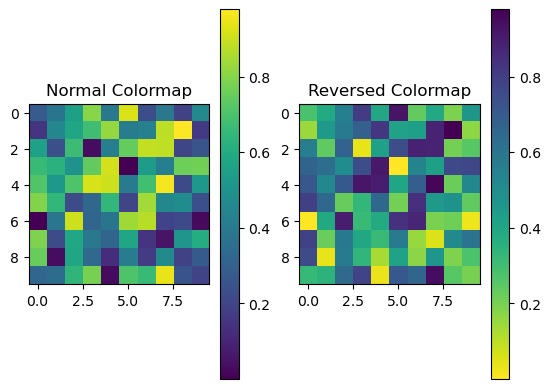

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Create some data
data = np.random.rand(10, 10)

# Plot using the normal colormap
plt.subplot(1, 2, 1)
plt.imshow(data, cmap='viridis')
plt.title('Normal Colormap')
plt.colorbar()

# Plot using the reversed colormap
plt.subplot(1, 2, 2)
plt.imshow(data, cmap='viridis_r')
plt.title('Reversed Colormap')
plt.colorbar()

plt.show()
